# Regional plots for D5.1, bar graphs, histograms

## it uses the masks created in the notebook called "regional_masks.ipynb"

Created by: Stella Bērziņa

Created on: 09.07.2025, code written earlier for the deliverable D5.1 but cleaned and organised on the date

## 0) Libraries

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import intake
from pathlib import Path
import dask
import pandas as pd
dask.config.set({"array.slicing.split_large_chunks": True}) 
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
import sys
from numpy import arange, ones

import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.cm import get_cmap
from matplotlib import colors 
from matplotlib.colors import ListedColormap
from matplotlib.figure import Figure
from matplotlib.ticker import FuncFormatter

from py_eddy_tracker.observations.network import NetworkObservations
from py_eddy_tracker.observations.observation import EddiesObservations, Table
from py_eddy_tracker.observations.tracking import TrackEddiesObservations
from py_eddy_tracker.dataset.grid import RegularGridDataset
from py_eddy_tracker.featured_tracking.area_tracker import AreaTracker
from py_eddy_tracker.gui import GUI
from py_eddy_tracker.tracking import Correspondances


from datetime import datetime, timedelta
from netCDF4 import Dataset

import io
import os

import warnings
warnings.filterwarnings("ignore")

# from concurrent.futures import ProcessPoolExecutor
# from concurrent.futures import ThreadPoolExecutor

import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point


import tol_colors as tc

## 1) read in all fields

These fields are created when I plot the global figures in a different notebook (add the name here)

In [1]:
field_path = "/work/bk1377/b382618/model_eddy_eval/property_fields_again/"

#### amplitude

In [4]:
amp_icon = xr.open_dataset(field_path + "icon_all_amplitude.nc")
amp_fe = xr.open_dataset(field_path + "fesom_all_amplitude.nc")
amp_met = xr.open_dataset(field_path + "met_all_amplitude.nc")
amp_obs = xr.open_dataset(field_path + "obs_all_amplitude.nc")
amp_mm = xr.open_dataset(field_path + "mm_all_amplitude.nc")


In [4]:
amp_list_data = [amp_icon, amp_fe, amp_met, amp_mm, amp_obs]
data_name_list = ["ICON", "IFS-FESOM", "HADGEM3 HH","HADGEM3 MM" ,"AVISO"]

#### radius

In [16]:
rad_icon = xr.open_dataset(field_path + "icon_all_radius.nc")
rad_fe = xr.open_dataset(field_path + "fesom_all_radius.nc")
rad_met = xr.open_dataset(field_path + "met_all_radius.nc")
rad_obs = xr.open_dataset(field_path + "obs_all_radius.nc")
rad_mm = xr.open_dataset(field_path + "mm_all_radius.nc")


In [17]:
rad_list_data = [rad_icon, rad_fe, rad_met, rad_mm, rad_obs]
data_name_list = ["ICON", "IFS-FESOM", "HADGEM3 HH","HADGEM3 MM" ,"AVISO"]

#### birth

In [5]:
birth_icon = xr.open_dataset(field_path + "icon_all_birth2.nc")
birth_fe = xr.open_dataset(field_path + "fesom_all_birth2.nc")
birth_met = xr.open_dataset(field_path + "met_all_birth2.nc")
birth_obs = xr.open_dataset(field_path + "obs_all_birth2.nc")
birth_mm = xr.open_dataset(field_path + "mm_all_birth2.nc")


In [6]:
birth_list_data = [birth_icon, birth_fe, birth_met,birth_mm, birth_obs]
data_name_list = ["ICON", "IFS-FESOM", "HADGEM3 HH","HADGEM3 MM" ,"AVISO"]

#### death

In [199]:
death_icon = xr.open_dataset(field_path + "icon_all_death.nc")
death_fe = xr.open_dataset(field_path + "fesom_all_death.nc")
death_met = xr.open_dataset(field_path + "met_all_death.nc")
death_obs = xr.open_dataset(field_path + "obs_all_death.nc")
death_mm = xr.open_dataset(field_path + "mm_all_death.nc")


In [200]:
death_list_data = [death_icon, death_fe, death_met, death_mm,death_obs]
data_name_list = ["ICON", "IFS-FESOM", "HADGEM3 HH","HADGEM3 MM" ,"AVISO"]

#### frequency

In [7]:
freq_icon = xr.open_dataset(field_path + "icon_all_freq.nc")
freq_fe = xr.open_dataset(field_path + "fesom_all_freq.nc")
freq_met = xr.open_dataset(field_path + "met_all_freq.nc")
freq_obs = xr.open_dataset(field_path + "obs_all_freq.nc")
freq_mm = xr.open_dataset(field_path + "mm_all_freq.nc")


In [8]:


freq_list_data = [freq_icon, freq_fe, freq_met, freq_mm,freq_obs]
data_name_list = ["ICON", "IFS-FESOM", "HADGEM3 HH","HADGEM3 MM" ,"AVISO"]

#### masks

In [7]:
# mask with 5 regions used in D5.1
mask3deg = xr.open_dataset("/home/b/b382618/IPYNBS/notebooks_for_d5.1/paper/field_files/3deg_region_mask.nc")
mask1deg = xr.open_dataset("/home/b/b382618/IPYNBS/notebooks_for_d5.1/paper/field_files/1deg_region_mask_eq.nc")

In [8]:
mask1deg2 = mask1deg.rename({"lat": "y"})
mask1deg2 = mask1deg2.rename({"lon": "x"})
### this is so stupid but you need these masks to run the masks for radius. don't ask ...

## 2) histograms different versions (kept for just funzies)

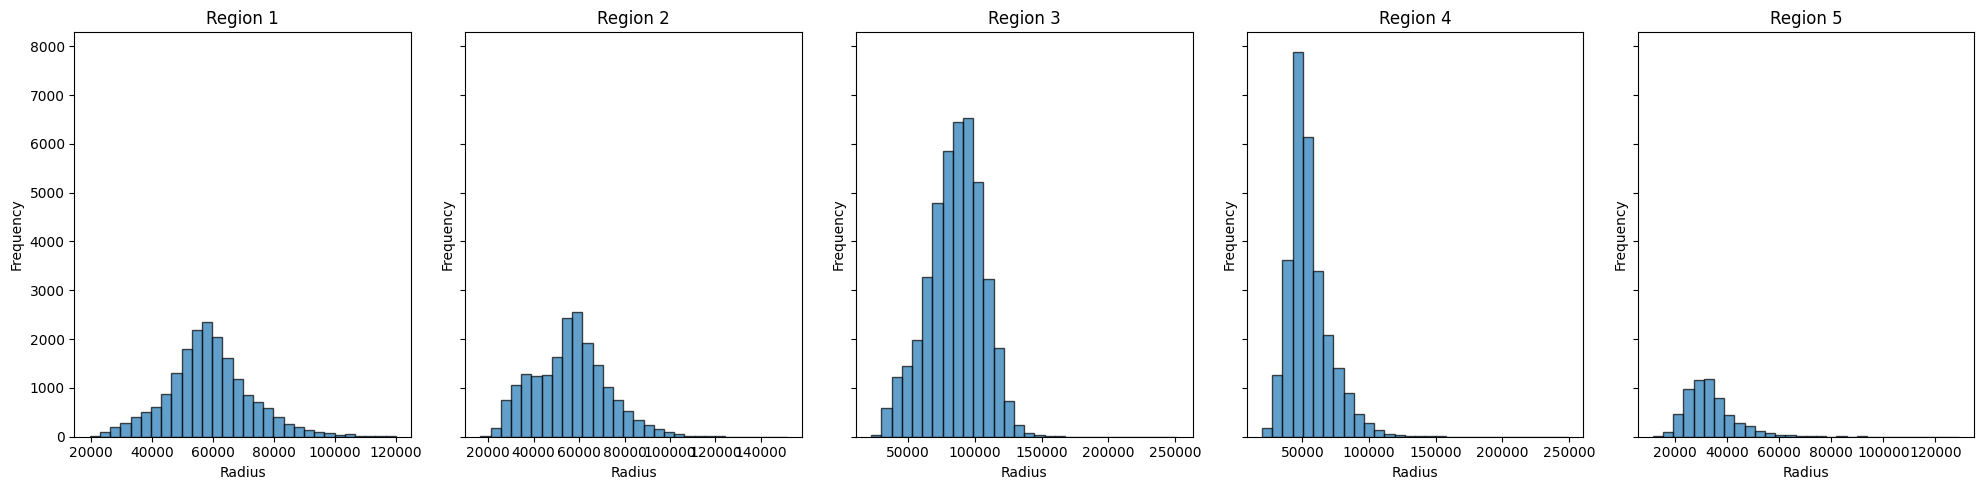

In [26]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

results = []  # Empty list to store results

for i in np.arange(0, 5):
    to_mask = rad_list_data[i]
    to_mask_nan = to_mask["radius_s"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    

    for reg in np.arange(1, 6):
        region = to_mask_nan_w.where(mask1deg2.region_mask == reg)
        region_values = region.values.flatten()  # Flatten array to 1D
        region_values = region_values[~np.isnan(region_values)]  # Remove NaNs
        
        # Store data for histogram
        results.append({
            "Model": data_name_list[i],
            "Region": reg,
            "Values": region_values  # Store all values instead of mean
        })

# Plot histograms for each region
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for idx, reg in enumerate(range(1, 6)):
    all_values = np.concatenate([r["Values"] for r in results if r["Region"] == reg])
    
    axes[idx].hist(all_values, bins=30, edgecolor="black", alpha=0.7)
    axes[idx].set_title(f"Region {reg}")
    axes[idx].set_xlabel("Radius")
    axes[idx].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


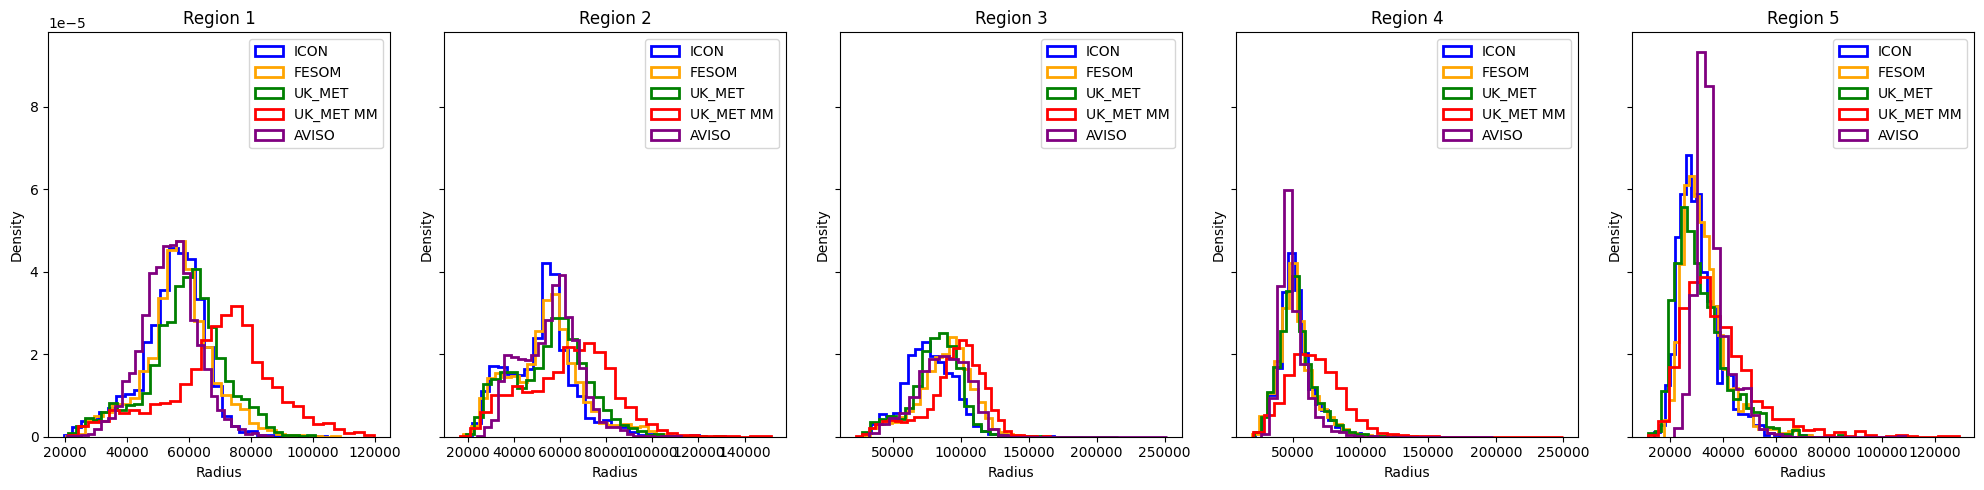

In [27]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

colors = ["blue", "orange", "green", "red", "purple"]  # Define colors for each dataset

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)  # One subplot per region

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    to_mask = rad_list_data[i]
    to_mask_nan = to_mask["radius_s"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg2.region_mask == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)]  # Remove NaNs

        # Plot histogram line (step style)
        axes[reg - 1].hist(region_values, bins=30, density=True, histtype="step", 
                           linewidth=2, label=data_name, color=colors[i])

# Formatting
for ax, reg in zip(axes, range(1, 6)):
    ax.set_title(f"Region {reg}")
    ax.set_xlabel("Radius")
    ax.set_ylabel("Density")
    ax.legend()  # Add legend to show dataset names

plt.tight_layout()
plt.show()


## 3) real regional histograms - used in the deliverable

#### Radius

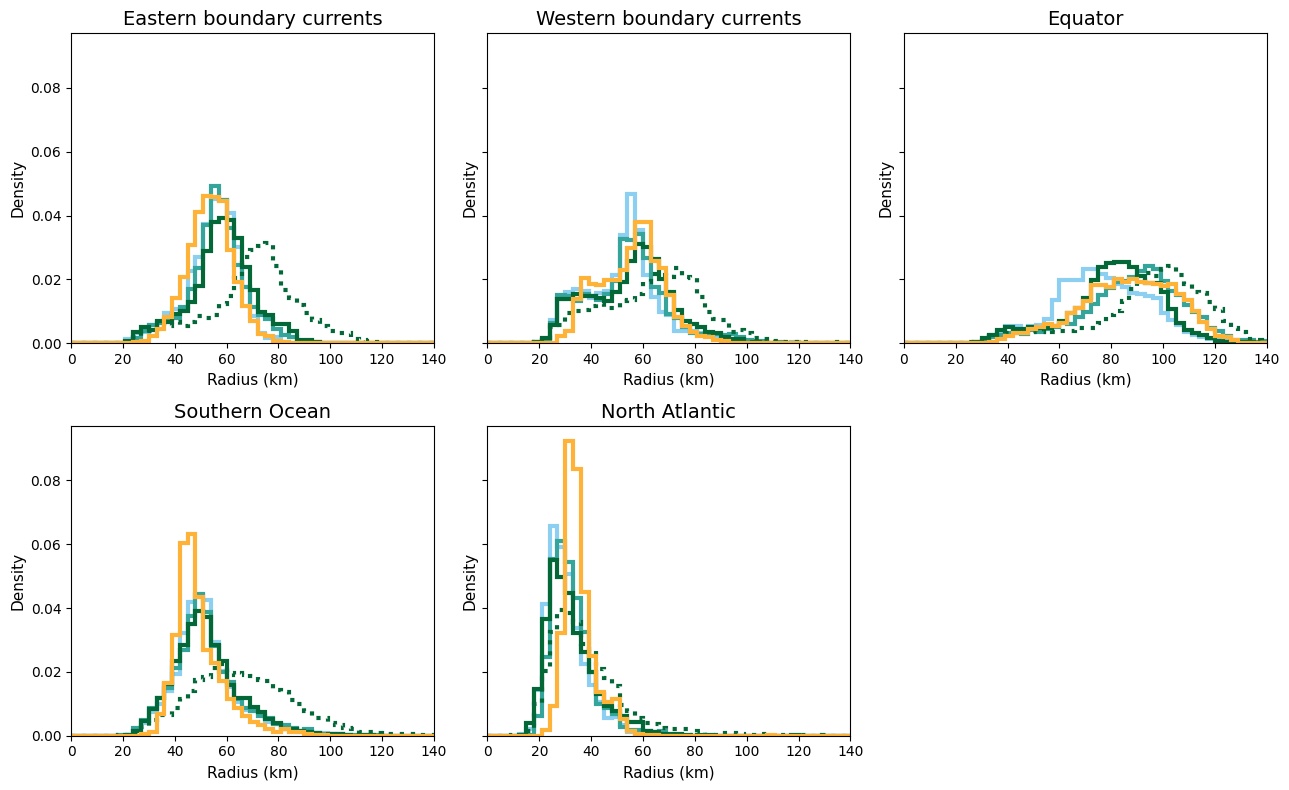

In [85]:


# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",   # Red (Dotted Line)
    "AVISO": "#ffb238",   # Yellow-Orange
}

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 140_000  # Set x-axis limit in meters
bin_width = 3_000  # Use smaller bins (1 km) for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width) / 1_000  # Convert bins to km

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    to_mask = rad_list_data[i]
    to_mask_nan = to_mask["radius_s"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg2.region_mask == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)] / 1_000  # Convert to km

        # Use the color from model_colors dictionary
        color = model_colors.get(data_name, "black")  # Default to black if not found

        # Set line style (dotted for "UK_MET MM", solid for others)
        linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

        # Plot histogram line (step style) with assigned color & linestyle
        axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                           linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)  # Set title using mapping
        ax.set_xlabel("Radius (km)", fontsize=11)  # Label in km
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max / 1_000)  # Convert x-axis limit to km
        # ax.legend()  # Add legend to each subplot
    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()
# plt.show()


# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/hist_region.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_radius.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_radius.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


#### Amplitude

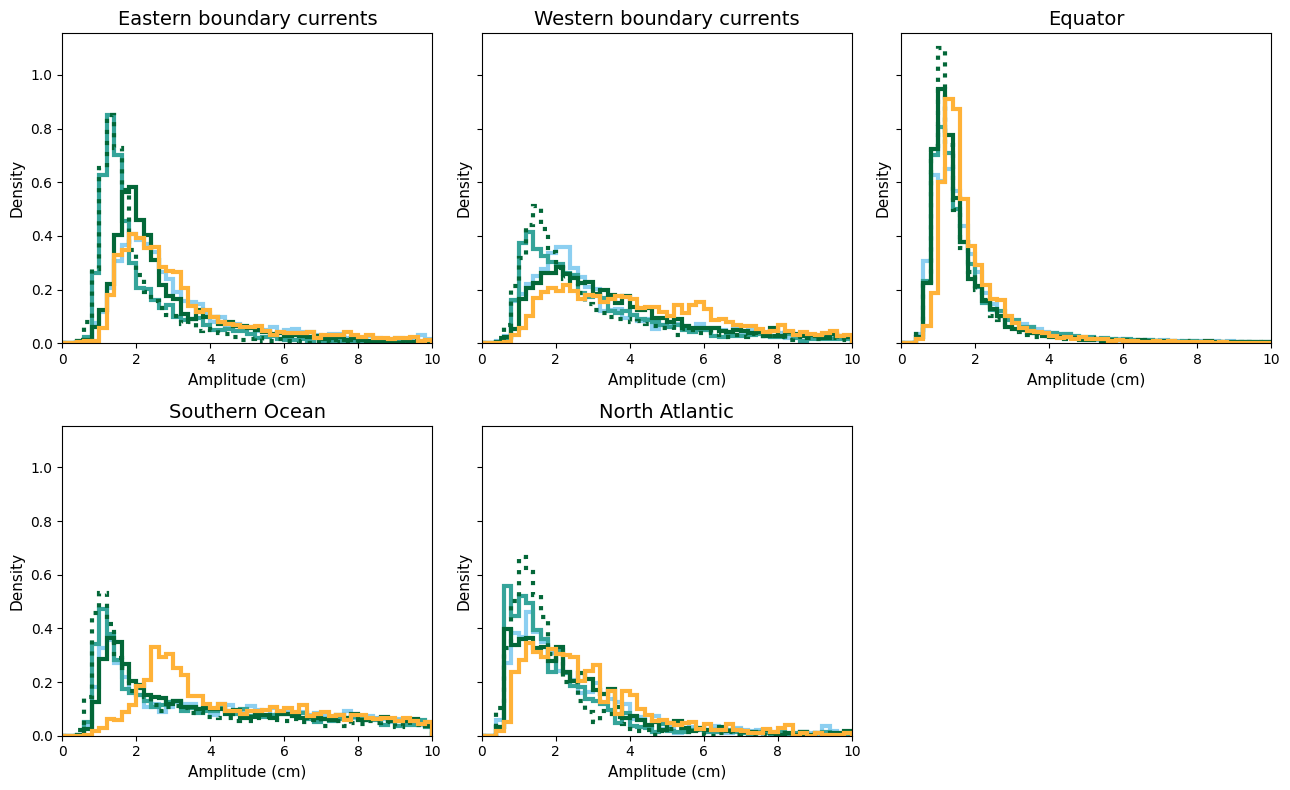

In [86]:


# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",   # Red (Dotted Line)
    "AVISO": "#ffb238",   # Yellow-Orange
}

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 0.1  # Set x-axis limit in meters
bin_width = 0.002  # Use smaller bins for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width) * 100  # Convert bins to cm

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    to_mask = amp_list_data[i]
    to_mask_nan = to_mask["amplitude"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg2.region_mask == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)] * 100  # Convert to cm

        # Use the color from model_colors dictionary
        color = model_colors.get(data_name, "black")  # Default to black if not found

        # Set line style (dotted for "UK_MET MM", solid for others)
        linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

        # Plot histogram line (step style) with assigned color & linestyle
        axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                           linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)  # Set title using mapping
        ax.set_xlabel("Amplitude (cm)", fontsize=11)  # Label in cm
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max * 100)  # Convert x-axis limit to cm
        # ax.legend()  # Add legend to each subplot
    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()
# plt.show()
# fig.suptitle('Regional amplitude distribution', fontsize=24)

# Save figures
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_amplitude.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_amplitude.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


#### Radius

In [ ]:

# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",  # Green (Dotted Line)
    "AVISO": "#ffb238",  # Yellow-Orange
}

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 200# Set x-axis limit in meters
bin_width = 5# Use smaller bins for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width)   # Convert bins to cm

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    if data_name_list[i]=="HADGEM3 MM":
        divider=19

    else:
        divider = 20
    
    # to_mask = death_list_data[i]
    # to_mask_nan = to_mask["count"].T
    # to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan) 
    to_mask = freq_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    
    to_mask_nan_w = to_mask_nan_w/divider 

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg.region_mask.values == reg)
        # print(region)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)]  # Convert to cm
        # print(region_values)
        # Use the color from model_colors dictionary
        color = model_colors.get(data_name, "black")  # Default to black if not found

        # Set line style (dotted for "UK_MET MM", solid for others)
        linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

        # Plot histogram line (step style) with assigned color & linestyle
        axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                           linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)  # Set title using mapping
        ax.set_xlabel("Occurence", fontsize=11)  # Label in cm
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max)  # Convert x-axis limit to cm
        # ax.legend()  # Add legend to each subplot
    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()
# plt.show()
# fig.suptitle('Regional amplitude distribution', fontsize=24)

# Save figures
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_occurence.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_occurence.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


#### Occurence

In [ ]:

# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",  # Green (Dotted Line)
    "AVISO": "#ffb238",  # Yellow-Orange
}

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 200# Set x-axis limit in meters
bin_width = 5# Use smaller bins for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width)   # Convert bins to cm

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    if data_name_list[i]=="HADGEM3 MM":
        divider=19

    else:
        divider = 20
    
    # to_mask = death_list_data[i]
    # to_mask_nan = to_mask["count"].T
    # to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan) 
    to_mask = freq_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    
    to_mask_nan_w = to_mask_nan_w/divider 

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg.region_mask.values == reg)
        # print(region)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)]  # Convert to cm
        # print(region_values)
        # Use the color from model_colors dictionary
        color = model_colors.get(data_name, "black")  # Default to black if not found

        # Set line style (dotted for "UK_MET MM", solid for others)
        linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

        # Plot histogram line (step style) with assigned color & linestyle
        axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                           linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)  # Set title using mapping
        ax.set_xlabel("Occurence", fontsize=11)  # Label in cm
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max)  # Convert x-axis limit to cm
        # ax.legend()  # Add legend to each subplot
    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()
# plt.show()
# fig.suptitle('Regional amplitude distribution', fontsize=24)

# Save figures
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_occurence.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_occurence.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [ ]:
###### with median values

# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",  # Green (Dotted Line)
    "AVISO": "#ffb238",  # Yellow-Orange
}

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 200  # Set x-axis limit in meters
bin_width = 5  # Use smaller bins for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width)  # Convert bins to cm

median_values = {reg: {} for reg in range(1, 6)}  # Dictionary to store median values

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    divider = 19 if data_name == "HADGEM3 MM" else 20
    
    to_mask = freq_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    
    to_mask_nan_w = to_mask_nan_w / divider

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg.region_mask.values == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)]  # Remove NaN values

        if len(region_values) > 0:
            median_val = np.median(region_values)
            median_values[reg][data_name] = median_val  # Store median values

            # Use the color from model_colors dictionary
            color = model_colors.get(data_name, "black")  # Default to black if not found
            linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

            # Plot histogram line (step style) with assigned color & linestyle
            axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                               linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)
        ax.set_xlabel("Occurrence", fontsize=11)
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max)

        # Add median values as annotations
        median_text = "\n".join([f"{model}: {median_values[idx + 1][model]:.1f}" 
                                 for model in median_values[idx + 1]])
        ax.text(0.95, 0.95, median_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right', 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()


# Save figures
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_occurence.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_occurence.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


#### Birth

In [ ]:
# import numpy as np
# import pandas as pd
# import xarray as xr
# import matplotlib.pyplot as plt

# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",   # Red (Dotted Line)
    "AVISO": "#ffb238",   # Yellow-Orange
}

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 40# Set x-axis limit in meters
bin_width = 1# Use smaller bins for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width)   # Convert bins to cm

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    if data_name_list[i]=="HADGEM3 MM":
        divider=19

    else:
        divider = 20
    
    to_mask = birth_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    
    to_mask_nan_w = to_mask_nan_w/divider 



    
    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask3deg.region_mask == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)] # Convert to cm

        # Use the color from model_colors dictionary
        color = model_colors.get(data_name, "black")  # Default to black if not found

        # Set line style (dotted for "UK_MET MM", solid for others)
        linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

        # Plot histogram line (step style) with assigned color & linestyle
        axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                           linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)  # Set title using mapping
        ax.set_xlabel("Eddy birth in 3 deg box per year", fontsize = 11)  # Label in cm
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max )  # Convert x-axis limit to cm
        # ax.legend()  # Add legend to each subplot
    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()
# plt.show()
# fig.suptitle('Regional amplitude distribution', fontsize=24)

# Save figures
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_birth.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_birth.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


#### Death

In [ ]:
# import numpy as np
# import pandas as pd
# import xarray as xr
# import matplotlib.pyplot as plt

# Define color mapping for each model
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",   # Red (Dotted Line)
    "AVISO": "#ffb238",   # Yellow-Orange
}
# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

fig, axes = plt.subplots(2, 3, figsize=(13, 8), sharey=True)  # 2 rows, 3 columns (wider format)
axes = axes.flatten()  # Flatten to access axes with a single index

x_max = 40# Set x-axis limit in meters
bin_width = 1# Use smaller bins for smoother histograms
bins = np.arange(0, x_max + bin_width, bin_width)   # Convert bins to cm

for i, data_name in enumerate(data_name_list):  # Iterate through datasets

    if data_name_list[i]=="HADGEM3 MM":
        divider=19

    else:
        divider = 20
    
    to_mask = death_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan) 
    to_mask_nan_w = to_mask_nan_w/divider 

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask3deg.region_mask == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)] # Convert to cm

        # Use the color from model_colors dictionary
        color = model_colors.get(data_name, "black")  # Default to black if not found

        # Set line style (dotted for "UK_MET MM", solid for others)
        linestyle = "dotted" if data_name == "HADGEM3 MM" else "solid"

        # Plot histogram line (step style) with assigned color & linestyle
        axes[reg - 1].hist(region_values, bins=bins, density=True, histtype="step", 
                           linewidth=3, linestyle=linestyle, label=data_name, color=color)

# Formatting
for idx, ax in enumerate(axes):
    if idx < 5:  # Only label existing regions
        ax.set_title(region_name_mapping[idx + 1], fontsize=14)  # Set title using mapping
        ax.set_xlabel("Eddy death in 3 deg box per year", fontsize=11)  # Label in cm
        ax.set_ylabel("Density", fontsize=11)
        ax.set_xlim(0, x_max )  # Convert x-axis limit to cm
        # ax.legend()  # Add legend to each subplot
    else:
        ax.axis("off")  # Hide extra subplot if there is one

plt.tight_layout()
# plt.show()
# fig.suptitle('Regional amplitude distribution', fontsize=24)

# Save figures
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_death.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/histograms_regional/hist_region_death.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


## 4) Calculate median values for regions and models

In [26]:
import numpy as np
import xarray as xr

# Define region names
region_name_mapping = {
    1: "Eastern boundary currents",
    2: "Western boundary currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

# Dictionary to store median values
median_values = {}

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    to_mask = rad_list_data[i]
    to_mask_nan = to_mask["radius_s"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    

    median_values[data_name] = {}

    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg2.region_mask == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)] /1000  # Convert to cm

        # Compute median and store it
        median_value = np.median(region_values)
        median_values[data_name][region_name_mapping[reg]] = median_value

# Print results
for model, regions in median_values.items():
    print(f"\nRegions: {model}")
    for model, median in regions.items():
        print(f"  {model}: {median:.2f} km")



Regions: ICON
  Eastern boundary currents: 55.78 km
  Western boundary currents: 53.52 km
  Equator: 75.87 km
  Southern Ocean: 50.37 km
  North Atlantic: 29.23 km

Regions: IFS-FESOM
  Eastern boundary currents: 56.77 km
  Western boundary currents: 54.41 km
  Equator: 90.05 km
  Southern Ocean: 50.58 km
  North Atlantic: 30.91 km

Regions: HADGEM3 HH
  Eastern boundary currents: 58.67 km
  Western boundary currents: 56.75 km
  Equator: 82.64 km
  Southern Ocean: 50.85 km
  North Atlantic: 30.48 km

Regions: HADGEM3 MM
  Eastern boundary currents: 71.76 km
  Western boundary currents: 65.51 km
  Equator: 98.32 km
  Southern Ocean: 64.85 km
  North Atlantic: 34.89 km

Regions: AVISO
  Eastern boundary currents: 53.83 km
  Western boundary currents: 56.79 km
  Equator: 87.38 km
  Southern Ocean: 47.22 km
  North Atlantic: 33.83 km


In [23]:
import numpy as np
import xarray as xr

# Dictionary to store global median values
global_median_values = {}

for i, data_name in enumerate(data_name_list):  # Iterate through datasets
    to_mask = rad_list_data[i]
    to_mask_nan = to_mask["radius_s"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    

    # Flatten the entire dataset and remove NaNs
    global_values = to_mask_nan_w.values.flatten()
    global_values = global_values[~np.isnan(global_values)] /1000  # Convert to cm

    # Compute median
    global_median_values[data_name] = np.median(global_values)

# Print results
print("\nGlobal Median Amplitudes:")
for model, median in global_median_values.items():
    print(f"  {model}: {median:.2f} km")



Global Median Amplitudes:
  ICON: 52.50 km
  IFS-FESOM: 54.21 km
  HADGEM3 HH: 55.76 km
  HADGEM3 MM: 68.66 km
  AVISO: 54.61 km


## 5) zonal plots 

This assumes that you have already read in the data at (1)

#### Amplitude

In [19]:
# this is needed because pyet adds as a nan value just a hhuuuge number which messes up statistics
amp_icon = xr.where(amp_icon >= 1000000, np.nan, amp_icon)    
amp_fe = xr.where(amp_fe >= 1000000, np.nan, amp_fe)    
amp_met = xr.where(amp_met >= 1000000, np.nan, amp_met)    
amp_mm = xr.where(amp_mm >= 1000000, np.nan, amp_mm)    
amp_obs = xr.where(amp_obs >= 1000000, np.nan, amp_obs)    


In [20]:
zonal_mean1 = amp_icon["amplitude"].mean(dim='x', skipna=True)
zonal_mean2 = amp_fe["amplitude"].mean(dim='x', skipna=True)
zonal_mean3 = amp_met["amplitude"].mean(dim='x', skipna=True)
zonal_mean4 = amp_mm["amplitude"].mean(dim='x', skipna=True)
zonal_mean5 = amp_obs["amplitude"].mean(dim='x', skipna=True)

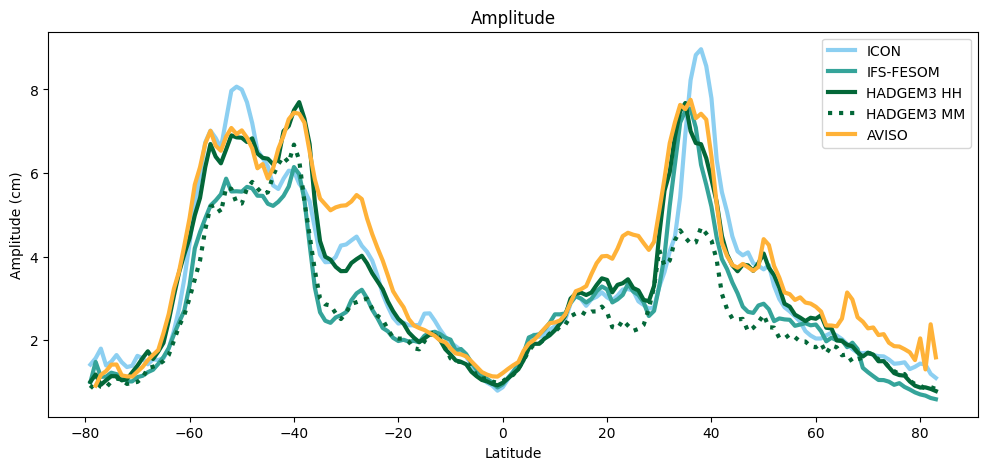

In [21]:
# Plotting
plt.figure(figsize=(12, 5))

zonal_mean1_cm = zonal_mean1 * 100
zonal_mean2_cm = zonal_mean2 * 100
zonal_mean3_cm = zonal_mean3 * 100
zonal_mean4_cm = zonal_mean4 * 100
zonal_mean5_cm = zonal_mean5 * 100

plt.plot(zonal_mean1_cm['y'], zonal_mean1_cm, color='#8CCFF1', label='ICON', lw=3)
plt.plot(zonal_mean2_cm['y'], zonal_mean2_cm, color='#35A49A', label='IFS-FESOM', lw=3)
plt.plot(zonal_mean3_cm['y'], zonal_mean3_cm, color='#036738', label='HADGEM3 HH', lw=3)
plt.plot(zonal_mean4_cm['y'], zonal_mean4_cm, color='#036738', label='HADGEM3 MM', linestyle="dotted", lw=3)
plt.plot(zonal_mean5_cm['y'], zonal_mean5_cm, color='#ffb238', label='AVISO', lw=3)

plt.xlabel('Latitude')
plt.ylabel('Amplitude (cm)')
plt.title('Amplitude')
plt.legend()

plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/zomal_mean_amplitude.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

#### Radius

In [90]:
rad_icon = xr.where(rad_icon >= 1000000, np.nan, rad_icon)    
rad_fe = xr.where(rad_fe >= 1000000, np.nan, rad_fe)    
rad_met = xr.where(rad_met >= 1000000, np.nan, rad_met)    
rad_mm = xr.where(rad_mm >= 1000000, np.nan, rad_mm)    
rad_obs = xr.where(rad_obs >= 1000000, np.nan, rad_obs)    


In [91]:
zonal_mean1 = rad_icon["radius_s"].mean(dim='x', skipna=True)
zonal_mean2 = rad_fe["radius_s"].mean(dim='x', skipna=True)
zonal_mean3 = rad_met["radius_s"].mean(dim='x', skipna=True)
zonal_mean4 = rad_mm["radius_s"].mean(dim='x', skipna=True)
zonal_mean5 = rad_obs["radius_s"].mean(dim='x', skipna=True)

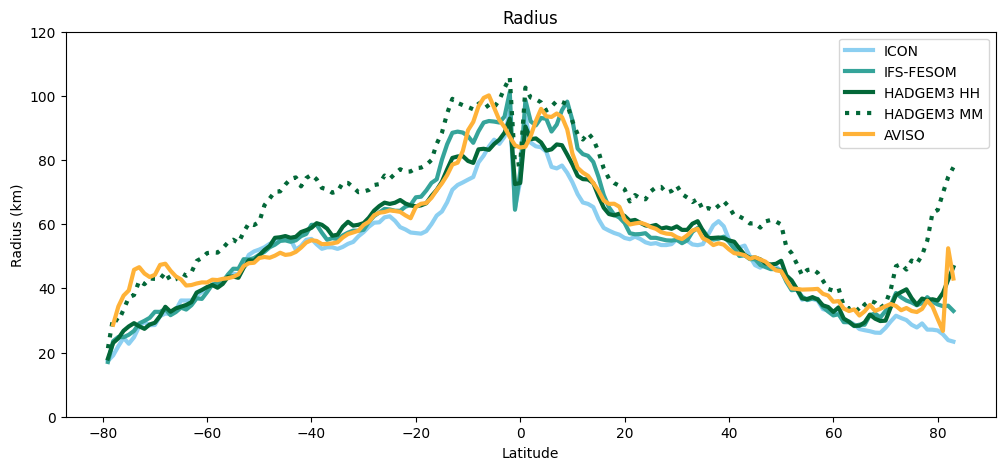

In [93]:
# Plotting
plt.figure(figsize=(12, 5))

zonal_mean1_cm = zonal_mean1 / 1000
zonal_mean2_cm = zonal_mean2 / 1000
zonal_mean3_cm = zonal_mean3 / 1000
zonal_mean4_cm = zonal_mean4 / 1000
zonal_mean5_cm = zonal_mean5 / 1000

plt.plot(zonal_mean1_cm['y'], zonal_mean1_cm, color='#8CCFF1', label='ICON', lw=3)
plt.plot(zonal_mean2_cm['y'], zonal_mean2_cm, color='#35A49A', label='IFS-FESOM', lw=3)
plt.plot(zonal_mean3_cm['y'], zonal_mean3_cm, color='#036738', label='HADGEM3 HH', lw=3)
plt.plot(zonal_mean4_cm['y'], zonal_mean4_cm, color='#036738', label='HADGEM3 MM', linestyle="dotted", lw=3)
plt.plot(zonal_mean5_cm['y'], zonal_mean5_cm, color='#ffb238', label='AVISO', lw=3)

plt.xlabel('Latitude')
plt.ylabel('Radius (km)')
plt.title('Radius')
plt.legend()
plt.ylim(0, 120)

plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/zomal_mean_radius.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

##### add rossby radius

In [47]:
path = '/home/b/b382615/public/RossbyRadius_ICON_raw_regrid.nc'
ro = xr.open_dataset(path)
ro

<xarray.Dataset>
Dimensions:                        (lat: 1800, lon: 3600)
Coordinates:
  * lat                            (lat) float64 -90.0 -89.9 -89.8 ... 89.8 89.9
  * lon                            (lon) float64 -180.0 -179.9 ... 179.8 179.9
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 ...

In [55]:
zonal_meanro = ro["__xarray_dataarray_variable__"].mean(dim="lon", skipna=True)
zonal_meanro

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 1800)>
array([        nan,         nan,         nan, ..., 12.58260458,
       15.83568849, 21.2544998 ])
Coordinates:
  * lat      (lat) float64 -90.0 -89.9 -89.8 -89.7 -89.6 ... 89.6 89.7 89.8 89.9

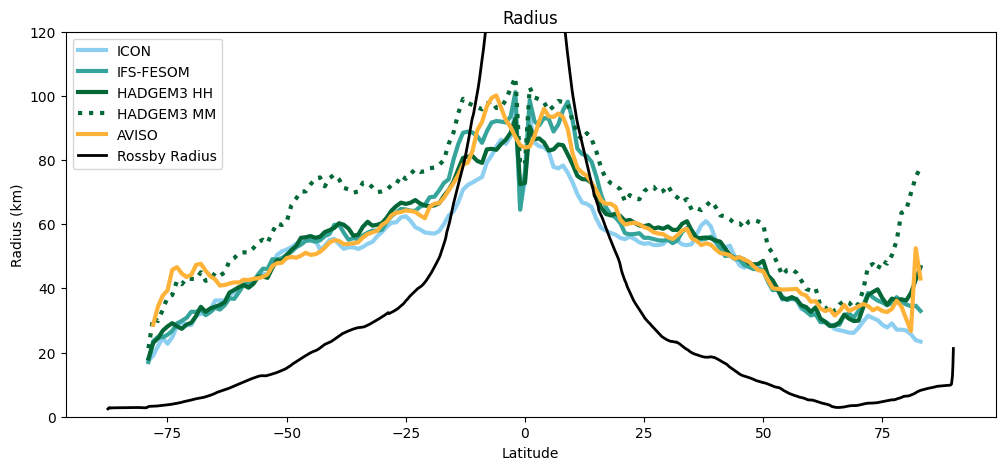

In [94]:
# Plotting
plt.figure(figsize=(12, 5))

zonal_mean1_cm = zonal_mean1 / 1000
zonal_mean2_cm = zonal_mean2 / 1000
zonal_mean3_cm = zonal_mean3 / 1000
zonal_mean4_cm = zonal_mean4 / 1000
zonal_mean5_cm = zonal_mean5 / 1000
zonal_meanro_cm = zonal_meanro 


plt.plot(zonal_mean1_cm['y'], zonal_mean1_cm, color='#8CCFF1', label='ICON', lw=3)
plt.plot(zonal_mean2_cm['y'], zonal_mean2_cm, color='#35A49A', label='IFS-FESOM', lw=3)
plt.plot(zonal_mean3_cm['y'], zonal_mean3_cm, color='#036738', label='HADGEM3 HH', lw=3)
plt.plot(zonal_mean4_cm['y'], zonal_mean4_cm, color='#036738', label='HADGEM3 MM', linestyle="dotted", lw=3)
plt.plot(zonal_mean5_cm['y'], zonal_mean5_cm, color='#ffb238', label='AVISO', lw=3)
plt.plot(zonal_meanro['lat'], zonal_meanro, color='black', label='Rossby Radius', lw=2)

plt.xlabel('Latitude')
plt.ylabel('Radius (km)')
plt.title('Radius')
plt.legend()
plt.ylim(0, 120)


plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/zomal_mean_radius_with_ro.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

#### Birth

In [41]:
birth_icon = xr.where(birth_icon >= 1000000, np.nan, birth_icon)    
birth_fe = xr.where(birth_fe >= 1000000, np.nan, birth_fe)    
birth_met = xr.where(birth_met >= 1000000, np.nan, birth_met)    
birth_mm = xr.where(birth_mm >= 1000000, np.nan, birth_mm)    
birth_obs = xr.where(birth_obs >= 1000000, np.nan, birth_obs)    


In [42]:
zonal_mean1_b = birth_icon["count"].mean(dim='lon', skipna=True)
zonal_mean2_b = birth_fe["count"].mean(dim='lon', skipna=True)
zonal_mean3_b = birth_met["count"].mean(dim='lon', skipna=True)
zonal_mean4_b = birth_mm["count"].mean(dim='lon', skipna=True)
zonal_mean5_b = birth_obs["count"].mean(dim='lon', skipna=True)

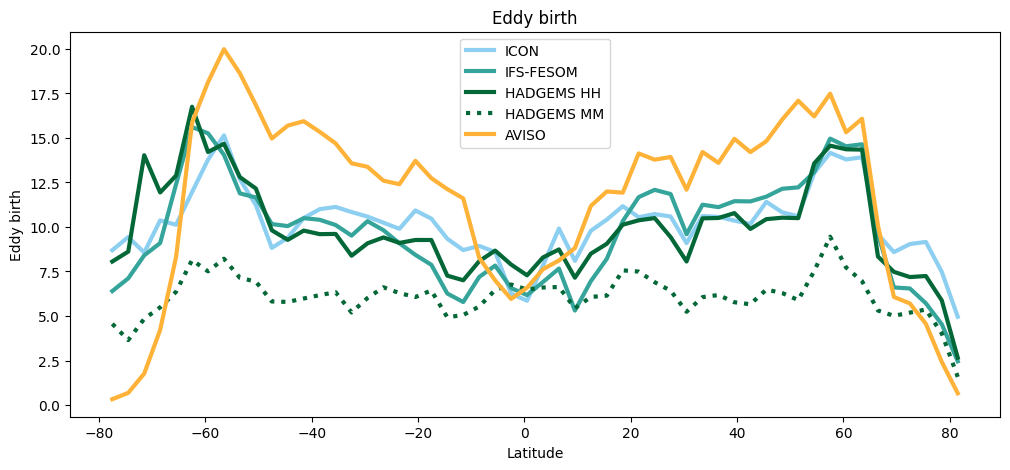

In [43]:
# Plotting
plt.figure(figsize=(12, 5))

zonal_mean1_cm = zonal_mean1_b /20
zonal_mean2_cm = zonal_mean2_b /20
zonal_mean3_cm = zonal_mean3_b /20
zonal_mean4_cm = zonal_mean4_b /19
zonal_mean5_cm = zonal_mean5_b /20

plt.plot(zonal_mean1_cm['lat'], zonal_mean1_cm, color='#8CCFF1', label='ICON', lw=3)
plt.plot(zonal_mean2_cm['lat'], zonal_mean2_cm, color='#35A49A', label='IFS-FESOM', lw=3)
plt.plot(zonal_mean3_cm['lat'], zonal_mean3_cm, color='#036738', label='HADGEMS HH', lw=3)
plt.plot(zonal_mean4_cm['lat'], zonal_mean4_cm, color='#036738', label='HADGEMS MM', linestyle="dotted", lw=3)
plt.plot(zonal_mean5_cm['lat'], zonal_mean5_cm, color='#ffb238', label='AVISO', lw=3)

plt.xlabel('Latitude')
plt.ylabel('Eddy birth')
plt.title('Eddy birth')
plt.legend()

plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/zomal_mean_birth.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

#### Death

In [44]:
death_icon = xr.where(death_icon >= 1000000, np.nan, death_icon)    
death_fe = xr.where(death_fe >= 1000000, np.nan, death_fe)    
death_met = xr.where(death_met >= 1000000, np.nan, death_met)    
death_mm = xr.where(death_mm >= 1000000, np.nan, death_mm)    
death_obs = xr.where(death_obs >= 1000000, np.nan, death_obs)    


In [45]:
zonal_mean1 = death_icon["count"].mean(dim='lon', skipna=True)
zonal_mean2 = death_fe["count"].mean(dim='lon', skipna=True)
zonal_mean3 = death_met["count"].mean(dim='lon', skipna=True)
zonal_mean4 = death_mm["count"].mean(dim='lon', skipna=True)
zonal_mean5 = death_obs["count"].mean(dim='lon', skipna=True)

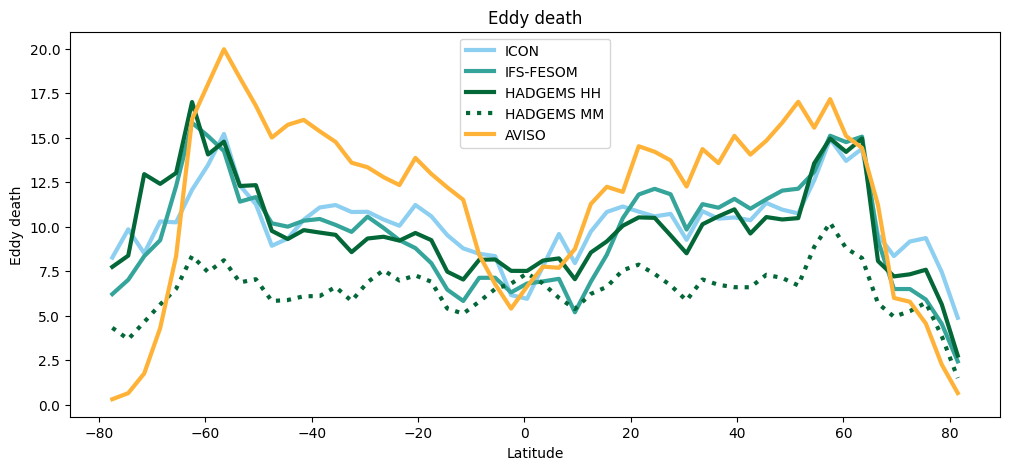

In [46]:
# Plotting
plt.figure(figsize=(12, 5))

zonal_mean1_d = zonal_mean1 /20
zonal_mean2_d = zonal_mean2 /20
zonal_mean3_d = zonal_mean3 /20
zonal_mean4_d = zonal_mean4 /19
zonal_mean5_d = zonal_mean5 /20

plt.plot(zonal_mean1_d['lat'], zonal_mean1_d, color='#8CCFF1', label='ICON', lw=3)
plt.plot(zonal_mean2_d['lat'], zonal_mean2_d, color='#35A49A', label='IFS-FESOM', lw=3)
plt.plot(zonal_mean3_d['lat'], zonal_mean3_d, color='#036738', label='HADGEMS HH', lw=3)
plt.plot(zonal_mean4_d['lat'], zonal_mean4_d, color='#036738', label='HADGEMS MM', linestyle="dotted", lw=3)
plt.plot(zonal_mean5_d['lat'], zonal_mean5_d, color='#ffb238', label='AVISO', lw=3)

plt.xlabel('Latitude')
plt.ylabel('Eddy death')
plt.title('Eddy death')
plt.legend()

plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/zomal_mean_death.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

#### Occurence frequency

In [208]:
freq_icon = xr.where(freq_icon >= 1000000, np.nan, freq_icon)    
freq_fe = xr.where(freq_fe >= 1000000, np.nan, freq_fe)    
freq_met = xr.where(freq_met >= 1000000, np.nan, freq_met)    
freq_mm = xr.where(freq_mm >= 1000000, np.nan, freq_mm)    
freq_obs = xr.where(freq_obs >= 1000000, np.nan, freq_obs)    


In [209]:
zonal_mean1 = freq_icon["count"].mean(dim='lon', skipna=True)
zonal_mean2 = freq_fe["count"].mean(dim='lon', skipna=True)
zonal_mean3 = freq_met["count"].mean(dim='lon', skipna=True)
zonal_mean4 = freq_mm["count"].mean(dim='lon', skipna=True)
zonal_mean5 = freq_obs["count"].mean(dim='lon', skipna=True)

In [210]:
zonal_mean1_d = zonal_mean1 /20
zonal_mean2_d = zonal_mean2 /20
zonal_mean3_d = zonal_mean3 /20
zonal_mean4_d = zonal_mean4 /19
zonal_mean5_d = zonal_mean5 /20
## to get annaul

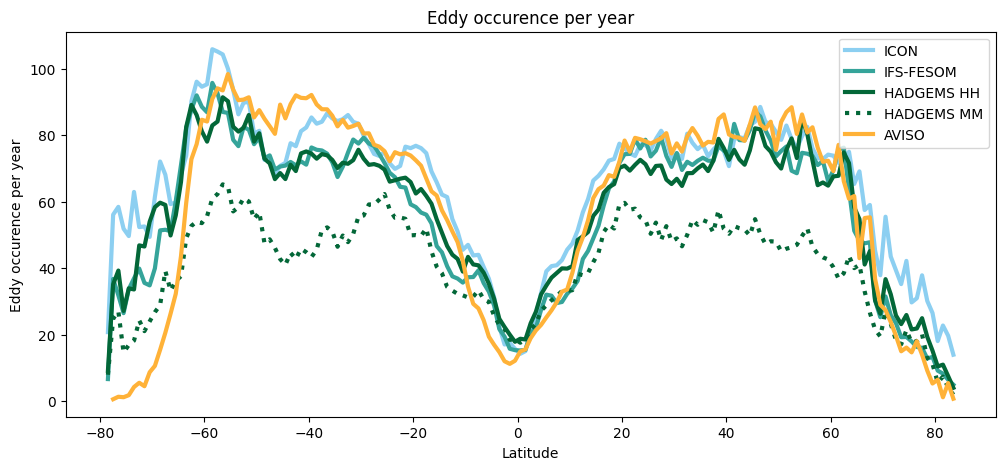

In [12]:
plt.figure(figsize=(12, 5))

zonal_mean1_d = zonal_mean1 /20
zonal_mean2_d = zonal_mean2 /20
zonal_mean3_d = zonal_mean3 /20
zonal_mean4_d = zonal_mean4 /19
zonal_mean5_d = zonal_mean5 /20

plt.plot(zonal_mean1_d['lat'], zonal_mean1_d, color='#8CCFF1', label='ICON', lw=3)
plt.plot(zonal_mean2_d['lat'], zonal_mean2_d, color='#35A49A', label='IFS-FESOM', lw=3)
plt.plot(zonal_mean3_d['lat'], zonal_mean3_d, color='#036738', label='HADGEMS HH', lw=3)
plt.plot(zonal_mean4_d['lat'], zonal_mean4_d, color='#036738', label='HADGEMS MM', linestyle="dotted", lw=3)
plt.plot(zonal_mean5_d['lat'], zonal_mean5_d, color='#ffb238', label='AVISO', lw=3)

plt.xlabel('Latitude')
plt.ylabel('Eddy occurence per year')
plt.title('Eddy occurence per year')
plt.legend()

plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/zomal_mean_freq.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

plt.show()

## 6) regional EKE

#### Read in the equator mask and the regional masks and the data

In [20]:
field_path = "/work/bk1377/b382618/model_eddy_eval/property_fields_again/"

In [18]:
# this is a regular regional mask
mask025deg = xr.open_dataset('/work/bk1377/b382618/model_eddy_eval/property_fields_again/025deg_region_mask.nc')


In [155]:
#this mask masks out the equator
mask025eq= xr.open_dataset('/work/bk1377/b382618/model_eddy_eval/property_fields_again/025deg_equator_mask.nc')


In [25]:
ic = xr.open_dataset("/home/b/b382615/TO_STELLA/EKE_mean_ICON.nc")
fe = xr.open_dataset("/home/b/b382615/TO_STELLA/EKE_mean_FESOM.nc")
obs = xr.open_dataset("/home/b/b382615/TO_STELLA/EKE_mean_AVISO.nc")
met = xr.open_dataset("/scratch/b/b382583/eke/HH/EKE_mean_HadGEM3-GC5E_HH.nc")
mm = xr.open_dataset("/scratch/b/b382583/eke/MM/EKE_mean_HadGEM3-GC5E_MM.nc")

FileNotFoundError: [Errno 2] No such file or directory: '/home/b/b382615/TO_STELLA/EKE_mean_ICON.nc'

In [24]:
eke_list_data = [ic, fe]


In [104]:
eke_list_datam = [mm, met]


In [97]:
## i think they are seperate because they have different lat and lon values
data_name_list = ["ICON", "IFS-FESOM"]
data_name_listm = ["HADGEM3 HH", "HADGEM3 MM"]


#### calculate eke for regions

In [54]:
# i am not sure what the to_mask here is
mask025deg2 = mask025deg.interp(
    lat=to_mask.lat.values,
    lon=to_mask.lon.values,  # if lon is also slightly different
    method="linear"  # you can also use 'nearest', 'cubic', etc.
)

In [98]:
results_eke = []  # Empty list to store results

for i in arange(0,2):
         
        to_mask = eke_list_data[i]
        # to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        for reg in arange(1,6):
            region = to_mask["__xarray_dataarray_variable__"].where(mask025deg.region_mask == reg)
            mean_value = region.mean(skipna=True)

            results_eke.append({
                "Model": data_name_list[i],
                "Region": reg,
                "Mean_amplitude": mean_value.values
            })
df_results_amplitude = pd.DataFrame(results_eke)
    

In [68]:
df_results_amplitude

,Model,Region,Mean_amplitude
0,ICON,1,0.010186994826899125
1,ICON,2,0.01777583695797137
2,ICON,3,inf
3,ICON,4,0.01638689769389455
4,ICON,5,0.0057276817884452476
5,IFS-FESOM,1,0.005782320512537353
6,IFS-FESOM,2,0.018522227968988683
7,IFS-FESOM,3,inf
8,IFS-FESOM,4,0.01236854404379442
9,IFS-FESOM,5,0.004296035519342035


##### observations have 721 lat, so we have to change that

In [99]:
# mask025deg

mask025deg2 = mask025deg.interp(
    lat=obs.lat.values,
    lon=obs.lon.values,  # if lon is also slightly different
    method="linear"  # you can also use 'nearest', 'cubic', etc.
)

In [101]:
results_eke = []  # Empty list to store results

for i in arange(0,1):
         
        to_mask = obs
        to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        for reg in arange(1,6):
            region = to_mask["__xarray_dataarray_variable__"].where(mask025deg2.region_mask == reg)
            mean_value = region.mean(skipna=True)

            results_eke.append({
                "Model": "AVISO",
                "Region": reg,
                "Mean_amplitude": mean_value.values
            })
df_results_eke = pd.DataFrame(results_eke)
    

In [102]:
df_results_eke

,Model,Region,Mean_amplitude
0,AVISO,1,0.009853691962676945
1,AVISO,2,0.02836172399513589
2,AVISO,3,0.02599769074360061
3,AVISO,4,0.0167976729865912
4,AVISO,5,0.0041936754930294905


In [117]:
results_ekem = []  # Empty list to store results

for i in arange(0,1):
         
        to_mask = mm
        to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        for reg in arange(1,6):
            region = to_mask["zos"].where(mask025deg.region_mask == reg)
            print(np.nanmean(region))
            mean_value = region.mean(skipna=True)

            results_ekem.append({
                "Model": "HADGEM3 MM",
                "Region": reg,
                "Mean_amplitude": mean_value.values
            })
df_results_amplitudem = pd.DataFrame(results_ekem)
df_results_amplitudem

0.004432736
0.011873266
0.17679201
0.010882787
0.0055207824


,Model,Region,Mean_amplitude
0,HADGEM3 MM,1,0.004432736
1,HADGEM3 MM,2,0.011873266
2,HADGEM3 MM,3,0.17679201
3,HADGEM3 MM,4,0.010882787
4,HADGEM3 MM,5,0.0055207824


In [120]:
results_ekem = []  # Empty list to store results

for i in arange(0,1):
         
        to_mask = met
        to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        for reg in arange(1,6):
            region = to_mask["zos"].where(mask025deg.region_mask == reg)
            print(np.nanmean(region))
            mean_value = region.mean(skipna=True)

            results_ekem.append({
                "Model": "HADGEM3 HH",
                "Region": reg,
                "Mean_amplitude": mean_value.values
            })
df_results_amplitudemet = pd.DataFrame(results_ekem)
df_results_amplitudemet

0.0065101455
0.017499467
0.18269104
0.01864592
0.0071685603


,Model,Region,Mean_amplitude
0,HADGEM3 HH,1,0.0065101455
1,HADGEM3 HH,2,0.017499467
2,HADGEM3 HH,3,0.18269104
3,HADGEM3 HH,4,0.01864592
4,HADGEM3 HH,5,0.0071685603


In [121]:
result = pd.concat([df_results_eke, df_results_amplitude, df_results_amplitudemet, df_results_amplitudem], axis=0)
result = result[result["Region"] != 3]


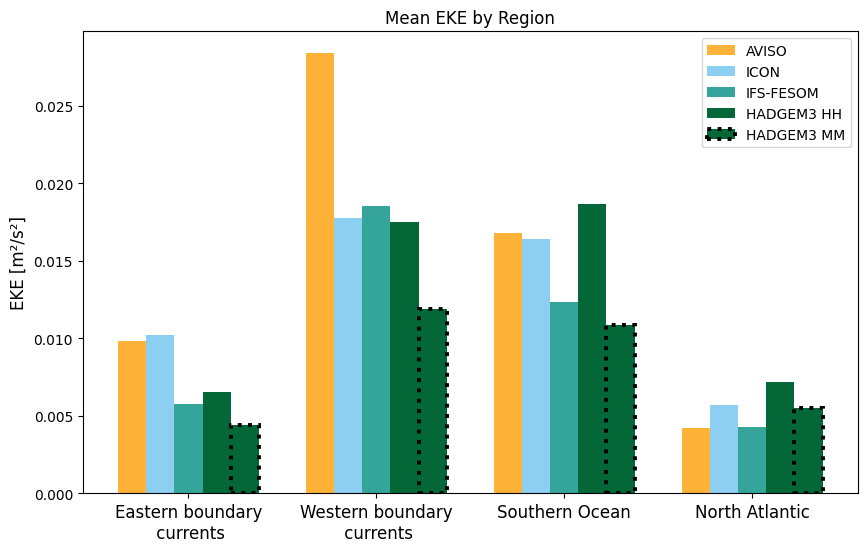

In [138]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique models and regions

df_results_amplitude=result
region_name_mapping = {
    1: "Eastern boundary\n currents",
    2: "Western boundary\n currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}
df_results_amplitude["Region_Name"] = df_results_amplitude["Region"].map(region_name_mapping)
models = df_results_amplitude["Model"].unique()
regions = df_results_amplitude["Region_Name"].unique()

model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Orange
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738", # Red
    "AVISO": "#ffb238",
} 

# Define bar width and positions
bar_width = 0.15  # Adjust for spacing
x = np.arange(len(regions))  # X locations for regions

# Create figure
plt.figure(figsize=(10, 6))

# Loop through models and plot bars
for i, model in enumerate(models):
    model_data = df_results_amplitude[df_results_amplitude["Model"] == model]
    mean_values = model_data["Mean_amplitude"].values

    # Plot filled bars
    bars = plt.bar(x + i * bar_width, mean_values, width=bar_width, 
                   color=model_colors.get(model, "gray"), label=model, edgecolor="none")

    # Add a dotted black outline for "HADGEM3 MM"
    if model == "HADGEM3 MM":
        for bar in bars:
            bar.set_edgecolor("black")  # Set outline color to black
            bar.set_linestyle("dotted")  # Make the outline dotted
            bar.set_linewidth(2.8)  # Adjust thickness of the outline
# Labeling
# plt.xlabel("Region")
superscript_2 = "\u00B2"
plt.ylabel(f"EKE [m{superscript_2}/s{superscript_2}]", fontsize=12)
plt.title("Mean EKE by Region")
plt.xticks(x + bar_width*2, regions, fontsize=12)  # Set x-ticks to region numbers
plt.legend()

# Show the plot
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/bar_plot_eke.png', dpi=300, bbox_inches='tight', pad_inches=0.1)




#### calculate global mean eke values

In [26]:
for i in arange(0,1):
         
        to_mask = met
        to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        region = to_mask["zos"].where(mask025eq.region_mask != 3)
        # print(np.nanmean(region))
        mean_value = region.mean(skipna=True)
mean_value.values



NameError: name 'met' is not defined

In [157]:
for i in arange(0,1):
         
        to_mask = mm
        # to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        region = to_mask["zos"].where(mask025eq.region_mask != 3)
        # print(np.nanmean(region))
        mean_value = region.mean(skipna=True)
mean_value.values



array(0.00625513, dtype=float32)

In [158]:
for i in arange(0,1):
         
        to_mask = ic
        # to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        region = to_mask["__xarray_dataarray_variable__"].where(mask025eq.region_mask != 3)
        # print(np.nanmean(region))
        mean_value = region.mean(skipna=True)
mean_value.values



array(0.0106472)

In [159]:
for i in arange(0,1):
         
        to_mask = fe
        # to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        region = to_mask["__xarray_dataarray_variable__"].where(mask025eq.region_mask != 3)
        # print(np.nanmean(region))
        mean_value = region.mean(skipna=True)
mean_value.values



array(0.00941199)

In [161]:
# mask025deg

mask025eq2 = mask025eq.interp(
    lat=obs.lat.values,
    lon=obs.lon.values,  # if lon is also slightly different
    method="linear"  # you can also use 'nearest', 'cubic', etc.
)

In [162]:
for i in arange(0,1):
         
        to_mask = obs
        # to_mask['lon'] = (((to_mask['lon'] + 180) % 360) - 180)
        to_mask = to_mask.sortby('lon')
        # to_mask_nan=to_mask["amplitude"].T
        # to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        region = to_mask["__xarray_dataarray_variable__"].where(mask025eq2.region_mask != 3)
        # print(np.nanmean(region))
        mean_value = region.mean(skipna=True)
mean_value.values



array(0.01395358)

In [165]:
results_m=[]

In [166]:
results_m.append({
                "Model": "HADGEM3 HH",
                "Region": "mean",
                "Mean_amplitude": 0.00878007
            })
# df_results_amplitudemet = pd.DataFrame(results_ekem)

In [167]:
results_m.append({
                "Model": "HADGEM3 MM",
                "Region": "mean",
                "Mean_amplitude": 0.00625513
            })

In [168]:

results_m.append({
                "Model": "ICON",
                "Region": "mean",
                "Mean_amplitude": 0.0106472
            })

In [169]:

results_m.append({
                "Model": "IFS-FESOM",
                "Region": "mean",
                "Mean_amplitude": 0.00941199
            })

In [170]:

results_m.append({
                "Model": "AVISO",
                "Region": "mean",
                "Mean_amplitude": 0.01395358
            })

In [171]:
results_m

[{'Model': 'HADGEM3 HH', 'Region': 'mean', 'Mean_amplitude': 0.00878007},
 {'Model': 'HADGEM3 MM', 'Region': 'mean', 'Mean_amplitude': 0.00625513},
 {'Model': 'ICON', 'Region': 'mean', 'Mean_amplitude': 0.0106472},
 {'Model': 'IFS-FESOM', 'Region': 'mean', 'Mean_amplitude': 0.00941199},
 {'Model': 'AVISO', 'Region': 'mean', 'Mean_amplitude': 0.01395358}]

In [176]:
df_results_meaneke = pd.DataFrame(results_m)


In [177]:
df_results_meaneke

,Model,Region,Mean_amplitude
0,HADGEM3 HH,mean,0.008780
1,HADGEM3 MM,mean,0.006255
2,ICON,mean,0.010647
3,IFS-FESOM,mean,0.009412
4,AVISO,mean,0.013954


In [178]:
result2 = pd.concat([result, df_results_meaneke], axis=0)


In [223]:
result2.to_pickle("/home/b/b382618/lifetime_files/eke_means.pkl")

In [25]:
obj = pd.read_pickle(r'/home/b/b382618/lifetime_files/eke_means.pkl')


In [26]:
obj

,Model,Region,Mean_amplitude,Region_Name
0,AVISO,1,0.009853691962676945,Eastern boundary\n currents
1,AVISO,2,0.02836172399513589,Western boundary\n currents
3,AVISO,4,0.0167976729865912,Southern Ocean
4,AVISO,5,0.0041936754930294905,North Atlantic
0,ICON,1,0.010186994826899125,Eastern boundary\n currents
1,ICON,2,0.01777583695797137,Western boundary\n currents
3,ICON,4,0.01638689769389455,Southern Ocean
4,ICON,5,0.0057276817884452476,North Atlantic
5,IFS-FESOM,1,0.005782320512537353,Eastern boundary\n currents
6,IFS-FESOM,2,0.018522227968988683,Western boundary\n currents


#### Final plot

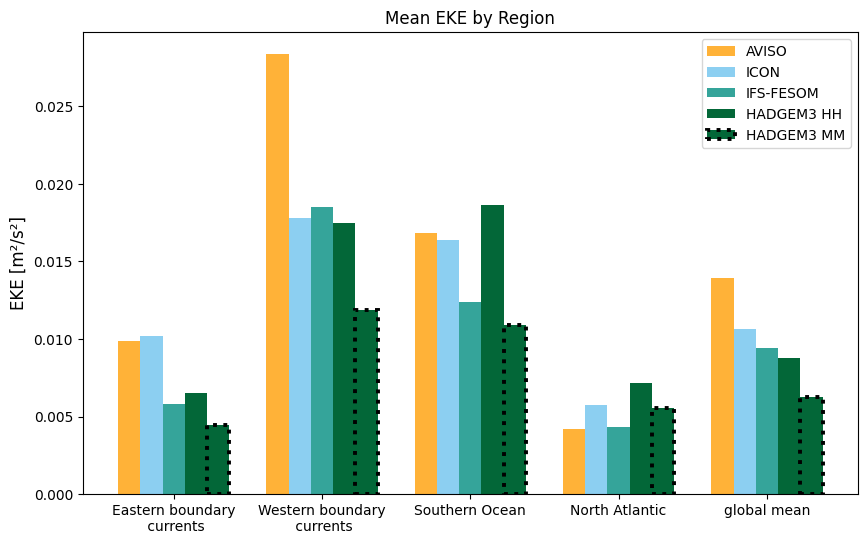

In [183]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique models and regions

df_results_amplitude=result2
region_name_mapping = {
    1: "Eastern boundary\n currents",
    2: "Western boundary\n currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic",
    "mean" : "global mean"
}
df_results_amplitude["Region_Name"] = df_results_amplitude["Region"].map(region_name_mapping)
models = df_results_amplitude["Model"].unique()
regions = df_results_amplitude["Region_Name"].unique()

model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Orange
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738", # Red
    "AVISO": "#ffb238",
} 

# Define bar width and positions
bar_width = 0.15  # Adjust for spacing
x = np.arange(len(regions))  # X locations for regions

# Create figure
plt.figure(figsize=(10, 6))

# Loop through models and plot bars
for i, model in enumerate(models):
    model_data = df_results_amplitude[df_results_amplitude["Model"] == model]
    mean_values = model_data["Mean_amplitude"].values

    # Plot filled bars
    bars = plt.bar(x + i * bar_width, mean_values, width=bar_width, 
                   color=model_colors.get(model, "gray"), label=model, edgecolor="none")

    # Add a dotted black outline for "HADGEM3 MM"
    if model == "HADGEM3 MM":
        for bar in bars:
            bar.set_edgecolor("black")  # Set outline color to black
            bar.set_linestyle("dotted")  # Make the outline dotted
            bar.set_linewidth(2.8)  # Adjust thickness of the outline
# Labeling
# plt.xlabel("Region")
superscript_2 = "\u00B2"
plt.ylabel(f"EKE [m{superscript_2}/s{superscript_2}]", fontsize=12)
plt.title("Mean EKE by Region")
plt.xticks(x + bar_width*2, regions, fontsize=10)  # Set x-ticks to region numbers
plt.legend()

# Show the plot
plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/bar_plot_eke_with_mean.png', dpi=300, bbox_inches='tight', pad_inches=0.1)




## 7) bar plot for regional eddy occurence - for science hour presentation

you need to have read in the data

In [25]:
results_freq = []  # Empty list to store results

for i in arange(0,5):
         
        to_mask = birth_list_data[i]

        to_mask_nan=to_mask["count"].T
        to_mask_nan_w = xr.where(to_mask_nan >= 1000000, np.nan, to_mask_nan)    
        for reg in arange(1,6):
            region = to_mask_nan_w.where(mask3deg.region_mask == reg)
            mean_value = region.mean(skipna=True)

            results_freq.append({
                "Model": data_name_list[i],
                "Region": reg,
                "Mean_birth": mean_value.values
            })
df_results_birth = pd.DataFrame(results_freq)
    

In [34]:
df_results_birth["annual"] = df_results_birth["Mean_birth"]/20

In [35]:
df_results_birth

,Model,Region,Mean_birth,Region_Name,annual
0,ICON,1,198.85434782608695,Eastern boundary\n currents,9.942717
1,ICON,2,230.54831460674157,Western boundary\n currents,11.527416
2,ICON,3,166.6810865191147,Equator,8.334054
3,ICON,4,210.47554806070826,Southern Ocean,10.523777
4,ICON,5,345.97872340425533,North Atlantic,17.298936
5,IFS-FESOM,1,196.75652173913045,Eastern boundary\n currents,9.837826
6,IFS-FESOM,2,227.36507936507937,Western boundary\n currents,11.368254
7,IFS-FESOM,3,133.2366026289181,Equator,6.66183
8,IFS-FESOM,4,216.97301854974705,Southern Ocean,10.848651
9,IFS-FESOM,5,335.2836879432624,North Atlantic,16.764184


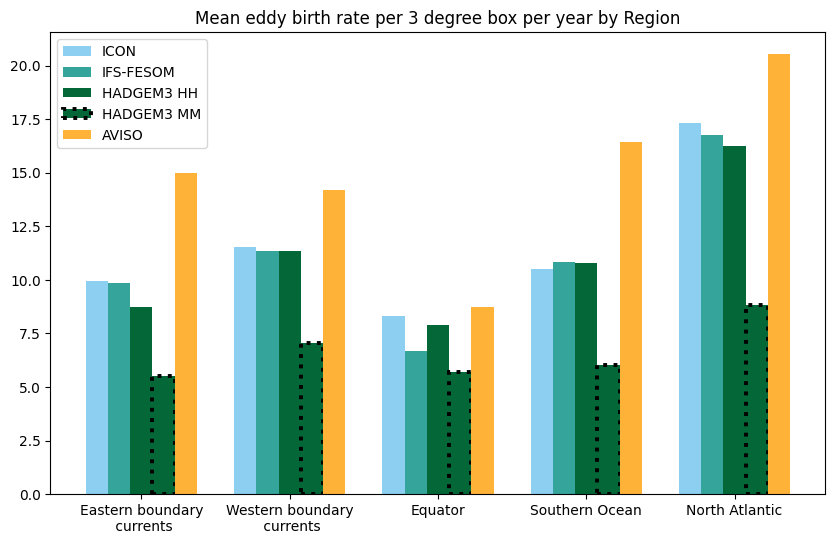

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique models and regions

df_results_amplitude=df_results_birth
region_name_mapping = {
    1: "Eastern boundary\n currents",
    2: "Western boundary\n currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic",
}
df_results_amplitude["Region_Name"] = df_results_amplitude["Region"].map(region_name_mapping)
models = df_results_amplitude["Model"].unique()
regions = df_results_amplitude["Region_Name"].unique()

model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Orange
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738", # Red
    "AVISO": "#ffb238",
} 

# Define bar width and positions
bar_width = 0.15  # Adjust for spacing
x = np.arange(len(regions))  # X locations for regions

# Create figure
plt.figure(figsize=(10, 6))

# Loop through models and plot bars
for i, model in enumerate(models):
    model_data = df_results_amplitude[df_results_amplitude["Model"] == model]
    mean_values = model_data["annual"].values

    # Plot filled bars
    bars = plt.bar(x + i * bar_width, mean_values, width=bar_width, 
                   color=model_colors.get(model, "gray"), label=model, edgecolor="none")

    # Add a dotted black outline for "HADGEM3 MM"
    if model == "HADGEM3 MM":
        for bar in bars:
            bar.set_edgecolor("black")  # Set outline color to black
            bar.set_linestyle("dotted")  # Make the outline dotted
            bar.set_linewidth(2.8)  # Adjust thickness of the outline
# Labeling
# plt.xlabel("Region")

plt.ylabel("", fontsize=12)
plt.title("Mean eddy birth rate per 3 degree box per year by Region")
plt.xticks(x + bar_width*2, regions, fontsize=10)  # Set x-ticks to region numbers
plt.legend()

# Show the plot
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/bar_plot_eke_with_mean.png', dpi=300, bbox_inches='tight', pad_inches=0.1)




## 8) The figure Niki wants - eke vs eddy number

### EKE

In [10]:
mean_eke = pd.read_pickle("/home/b/b382618/IPYNBS/notebooks_for_d5.1/lifetime_files/eke_means.pkl")


In [12]:
mean_eke

,Model,Region,Mean_amplitude,Region_Name
0,AVISO,1,0.009853691962676945,Eastern boundary\n currents
1,AVISO,2,0.02836172399513589,Western boundary\n currents
3,AVISO,4,0.0167976729865912,Southern Ocean
4,AVISO,5,0.0041936754930294905,North Atlantic
0,ICON,1,0.010186994826899125,Eastern boundary\n currents
1,ICON,2,0.01777583695797137,Western boundary\n currents
3,ICON,4,0.01638689769389455,Southern Ocean
4,ICON,5,0.0057276817884452476,North Atlantic
5,IFS-FESOM,1,0.005782320512537353,Eastern boundary\n currents
6,IFS-FESOM,2,0.018522227968988683,Western boundary\n currents


### occurence frequency

#### 1) read in data

In [13]:
freq_icon = xr.open_dataset(field_path + "icon_all_freq.nc")
freq_fe = xr.open_dataset(field_path + "fesom_all_freq.nc")
freq_met = xr.open_dataset(field_path + "met_all_freq.nc")
freq_obs = xr.open_dataset(field_path + "obs_all_freq.nc")
freq_mm = xr.open_dataset(field_path + "mm_all_freq.nc")

freq_list_data = [freq_icon, freq_fe, freq_met, freq_mm,freq_obs]
data_name_list = ["ICON", "IFS-FESOM", "HADGEM3 HH","HADGEM3 MM" ,"AVISO"]

#### 2) now i need to calculate the median occurence values in ceach of the regions

In [17]:


# Initialize an empty list to store results
median_results = []

# Define region name mapping
region_name_mapping = {
    1: "Eastern boundary\n currents",
    2: "Western boundary\n currents",
    3: "Equator",
    4: "Southern Ocean",
    5: "North Atlantic"
}

# Iterate through datasets
for i, data_name in enumerate(data_name_list):
    divider = 19 if data_name == "HADGEM3 MM" else 20
    
    to_mask = freq_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    
    to_mask_nan_w = to_mask_nan_w / divider
    
    for reg in range(1, 6):
        region = to_mask_nan_w.where(mask1deg.region_mask.values == reg)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)]  # Remove NaN values
        
        if len(region_values) > 0:
            median_val = np.median(region_values)
            # Append to results list
            median_results.append({
                'Region': region_name_mapping[reg],
                'Model': data_name,
                'Median Value': round(median_val, 1)
            })

df_median_regions = pd.DataFrame(median_results)

print(df_median_regions)

                         Region       Model  Median Value
0   Eastern boundary\n currents        ICON          77.2
1   Western boundary\n currents        ICON          73.1
2                       Equator        ICON          40.1
3                Southern Ocean        ICON          77.4
4                North Atlantic        ICON          94.0
5   Eastern boundary\n currents   IFS-FESOM          74.3
6   Western boundary\n currents   IFS-FESOM          67.4
7                       Equator   IFS-FESOM          30.8
8                Southern Ocean   IFS-FESOM          72.5
9                North Atlantic   IFS-FESOM          57.6
10  Eastern boundary\n currents  HADGEM3 HH          72.3
11  Western boundary\n currents  HADGEM3 HH          64.6
12                      Equator  HADGEM3 HH          35.4
13               Southern Ocean  HADGEM3 HH          72.4
14               North Atlantic  HADGEM3 HH          63.4
15  Eastern boundary\n currents  HADGEM3 MM          48.1
16  Western bo

#### 3) calculate median global frequency in each of the models

In [16]:

# Initialize an empty list to store results
median_results = []

# Define region name mapping
region_name_mapping = {
     "median",
}

# Iterate through datasets
for i, data_name in enumerate(data_name_list):
    divider = 19 if data_name == "HADGEM3 MM" else 20
    
    to_mask = freq_list_data[i]
    to_mask_nan = to_mask["count"].T
    to_mask_nan_w = xr.where(to_mask_nan >= 1_000_000, np.nan, to_mask_nan)    
    to_mask_nan_w = to_mask_nan_w / divider
    
    for reg in range(1):
        region = to_mask_nan_w.where(mask1deg.region_mask.values !=3)
        region_values = region.values.flatten()
        region_values = region_values[~np.isnan(region_values)]  # Remove NaN values
        
        if len(region_values) > 0:
            median_val = np.median(region_values)
            # Append to results list
            median_results.append({
                'Region': "median",
                'Model': data_name,
                'Median Value': round(median_val, 1)
            })

# Create DataFrame from the results list
df_median_models = pd.DataFrame(median_results)

print(df_median_models)


   Region       Model  Median Value
0  median        ICON          73.0
1  median   IFS-FESOM          65.4
2  median  HADGEM3 HH          65.1
3  median  HADGEM3 MM          42.6
4  median       AVISO          75.2


#### 4) merge both median frequency datasets

In [19]:
df_median_mer = pd.concat([df_median_models, df_median_regions], ignore_index=True, sort=False)
df_median_mer

,Region,Model,Median Value
0,median,ICON,73.0
1,median,IFS-FESOM,65.4
2,median,HADGEM3 HH,65.1
3,median,HADGEM3 MM,42.6
4,median,AVISO,75.2
5,Eastern boundary\n currents,ICON,77.2
6,Western boundary\n currents,ICON,73.1
7,Equator,ICON,40.1
8,Southern Ocean,ICON,77.4
9,North Atlantic,ICON,94.0


In [22]:
df_median_mer['Region'] = df_median_mer['Region'].str.replace('median','global mean')
## so i can plot it

### Figure

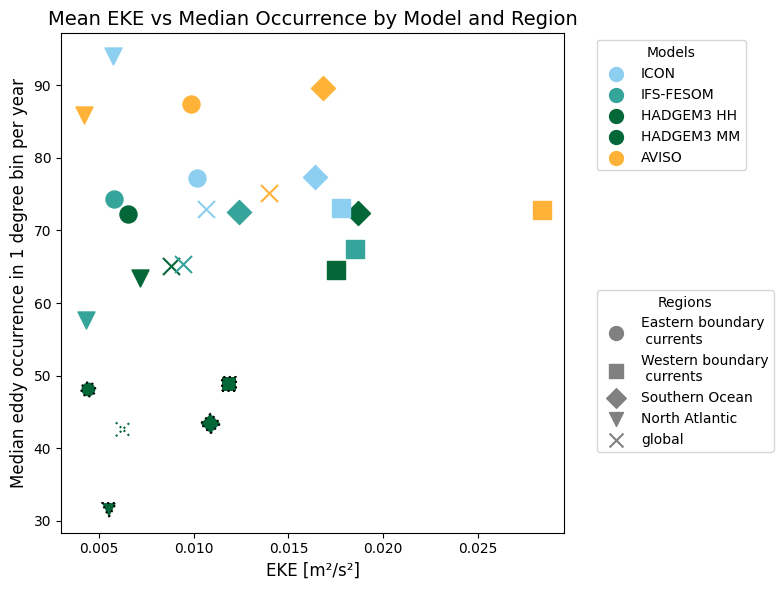

In [23]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd

# Create copies of the DataFrames
mean_eke_df = mean_eke.copy()
median_df = df_median_mer.copy()

# Rename the column in the median DataFrame to match
median_df = median_df.rename(columns={'Region': 'Region_Name'})

# Merge the DataFrames
merged_df = pd.merge(mean_eke_df, median_df, on=['Region_Name', 'Model'])

# Define color mapping for models
model_colors = {
    "ICON": "#8CCFF1",  # Blue
    "IFS-FESOM": "#35A49A",  # Teal
    "HADGEM3 HH": "#036738",  # Green
    "HADGEM3 MM": "#036738",  # Green (slightly different shade or transparency)
    "AVISO": "#ffb238",  # Yellow-Orange
}

# Define marker shapes for regions
region_markers = {
    "Eastern boundary\n currents": "o",
    "Western boundary\n currents": "s",
    "Equator": "^",
    "Southern Ocean": "D",
    "North Atlantic": "v",
    "global mean": "x"
}

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Plot points
for (region, model), group in merged_df.groupby(['Region_Name', 'Model']):
    # Special handling for HADGEM3 MM to add dotted black outline
    if model == "HADGEM3 MM":
        plt.scatter(
            group['Mean_amplitude'], 
            group['Median Value'], 
            color=model_colors.get(model, 'gray'),
            marker=region_markers.get(region, 'o'),
            s=100,  # Size of markers
            label=f"{model} - {region}",
            edgecolors='black',  # Black outline
            linewidth=1.5,  # Width of the outline
            linestyle='dotted'  # Dotted line style
        )
    else:
        plt.scatter(
            group['Mean_amplitude'], 
            group['Median Value'], 
            color=model_colors.get(model, 'gray'),
            marker=region_markers.get(region, 'o'),
            s=150,  # Size of markers
            label=f"{model} - {region}"
        )

superscript_2 = "\u00B2"
plt.xlabel(f"EKE [m{superscript_2}/s{superscript_2}]", fontsize=12)
plt.ylabel('Median eddy occurrence in 1 degree bin per year', fontsize=12)
plt.title('Mean EKE vs Median Occurrence by Model and Region', fontsize=14)

# Create first legend for models (colors)
model_legend_handles = [plt.scatter([], [], color=color, label=model, s=100) 
                        for model, color in model_colors.items() 
                        if model in merged_df['Model'].unique()]

# Create second legend for regions (shapes), change 'global mean' to 'global'
region_legend_handles = [plt.scatter([], [], marker=marker, color='gray', 
                                     label='global' if region == 'global mean' else region, s=100) 
                         for region, marker in region_markers.items() 
                         if region in merged_df['Region_Name'].unique()]

# First legend for models (colors)
first_legend = plt.legend(handles=model_legend_handles, 
                          title='Models', 
                          loc='upper left', 
                          bbox_to_anchor=(1.05, 1))

# Second legend for regions (shapes)
plt.gca().add_artist(first_legend)  # Keep first legend
plt.legend(handles=region_legend_handles, 
           title='Regions', 
           loc='upper left', 
           bbox_to_anchor=(1.05, 0.5))

plt.tight_layout()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.savefig('/home/b/b382618/eddy_figs/model_evaluation/scatter_eke_freq.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
